##  **ASSIGNMENT 2: Semantic Segmentation**
### Francesco Simonetti


In [39]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from ctypes import resize
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

### **1. Caricamento e Preprocessing delle Immagini e delle Maschere** ###


In questo codice, carichiamo le immagini e le relative maschere per l'addestramento di un modello di segmentazione.
<br><br> Riscala e Caricamento delle Immagini e delle Maschere <br>
Le immagini e le maschere vengono caricate dalle rispettive cartelle e ridimensionate alle dimensioni desiderate di 128x128 pixel. Questo assicura che tutte le immagini abbiano le stesse dimensioni e siano compatibili con il modello.

<br>Divisione dei Dati<br>
I dati vengono divisi in set di training e di validation utilizzando la funzione `train_test_split` dal modulo `sklearn.model_selection`. In questo caso, il 33% delle immagini verranno utilizzate come set di validation, mentre il restante 67% verrà utilizzato per il training del modello.

<br> Immagini di Test <br>
Alcune immagini sono state rimosse dal dataset e collocate nella cartella "test_data". Queste immagini verranno utilizzate per valutare le prestazioni del modello dopo l'allenamento sul set di training e di validation.



In [40]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # RGB

# image and mask for training path 
data_folder = "../training_data"
images_folder = os.path.join(data_folder, "horses")
masks_folder = os.path.join(data_folder, "masks")

train_ids = os.listdir(images_folder)

# array of images and maskssss
X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i, image_name in enumerate(train_ids):
    # read the image
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    # scale to desired size
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    # seve the sclaed image 
    X[i] = image
    
    # Read the corresponding mask
    mask_path = os.path.join(masks_folder, image_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # scale to desired size
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    # add 1 dimenction at the mask
    mask = np.expand_dims(mask, axis=-1)
    # save the sclaed mask 
    y[i] = mask

# Now X contain images and y contain the corresponding masks, both scaled 

# splitto per training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

### **2. Architettura U-Net** ###
L'rchitettura è basata sulla U-Net, una rete neurale convoluzionale utilizzata per compiti come segmentazione delle immagini. È composta da un encoder e un decoder, con connessioni skip tra i corrispondenti livelli dell'encoder e del decoder per trasferire informazioni dettagliate durante la ricostruzione. La struttura del modello si è basata sulla struttura della U-net presentata nel seguente articolo [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8604041) dove viene mostrata la seguente architettura: ..
<br><br>
![Img](https://drive.google.com/uc?export=view&id=1Ocse1AFURWeeybF5vT8wmxm8i-DiC9m3)

<br><br>
E' stato mantenuta la struttura della U-Net citata ma con una riduzione del numero di filtri nei blocchi sia dell'encoder che del decoder per ridurre il costo computazionale durante l'addestramento, poichè il modello mantiene comuqnue la capacità di catturare caratteristiche rilevanti.

**Encoder**<br>
Composto da una serie di blocchi convoluzionali seguiti da operazioni di max pooling. Ogni blocco convoluzionale riduce progressivamente la dimensione dell'immagine e aumenta la profondità delle caratteristiche estratte.<br>
<br>
**Decoder**<br>
Utilizza strati convoluzionali trasposti per eseguire l'up-sampling e ripristinare la dimensione originale dell'immagine. Sono state utilizzate operazioni di concatenazione con i corrispondenti strati dell'encoder consentono di incorporare informazioni dettagliate durante la ricostruzione.
<br>
**Motivazioni delle scelte:**<br>



In [41]:
import tensorflow as tf

# input definition
inputs = tf.keras.layers.Input(shape=(None, None, 3))

# convolutional block
def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same'):
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def encoder(inputs):
    c1 = conv_block(inputs, 16)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256)
    return c5, [c1, c2, c3, c4]


def decoder(inputs, encoder_output):
    c5, skips = encoder_output

    u1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat1 = tf.keras.layers.concatenate([u1, skips[3]], axis=3)
    c6 = conv_block(concat1, 128)

    u2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat2 = tf.keras.layers.concatenate([u2, skips[2]], axis=3)
    c7 = conv_block(concat2, 32)

    u3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    concat3 = tf.keras.layers.concatenate([u3, skips[1]], axis=3)
    c8 = conv_block(concat3, 32)

    u4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    concat4 = tf.keras.layers.concatenate([u4, skips[0]], axis=3)
    c9 = conv_block(concat4, 16)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return outputs





### **3. Training** ###

**Binary crossentropy**<br>
viene utilizzata questa metrica come loss poichè essendo la mschera un'immagine di pixeli binari l'errore tra output predetto e target può essere calcolato come la differenza tra pixel uguali rispetto a tutti i pixel.<br>

**Callbacks**<br>
Vengono definiti due callback da utilizzare durante l'addestramento del modello:<br>
EarlyStopping: interrompe l'addestramento se la perdita di convalida (val_loss) non migliora per 15 epoche consecutive, aiutando a prevenire l'overfitting.<br>
TensorBoard: registra i dati di addestramento per la visualizzazione con TensorBoard, uno strumento per il monitoraggio e la visualizzazione dell'addestramento del modello.

**Epochs**<br>
il numero di epoche è stato stabilito a 100 poichè dopo vari test ho notato che massimo intorno alle 80 epoche il training viene bloccato grazie al eraly stopping. 


In [42]:
encoder_output = encoder(inputs)

outputs = decoder(inputs, encoder_output)

# model creation 
model = tf.keras.models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

# training of the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=100, callbacks=callbacks)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5783 - loss: 4.0631 - val_accuracy: 0.7188 - val_loss: 0.6725
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7331 - loss: 0.6434 - val_accuracy: 0.7264 - val_loss: 0.5680
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7523 - loss: 0.5507 - val_accuracy: 0.7848 - val_loss: 0.4901
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7812 - loss: 0.5104 - val_accuracy: 0.7909 - val_loss: 0.4504
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7976 - loss: 0.4506 - val_accuracy: 0.8536 - val_loss: 0.3511
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8529 - loss: 0.3567 - val_accuracy: 0.8748 - val_loss: 0.3093
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8779 - loss: 0.3059 - val_accuracy: 0.8823 - val_loss: 0.2863
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8762 - loss: 0.2956 - val_accuracy: 0.8962 - v

### **3.1 Training plot** ### 
Questo codice mostra le curve di perdita durante l'addestramento del modello. La curva rossa rappresenta la perdita di addestramento (Training loss), mentre i punti blu indicano la perdita di convalida (Validation loss) ad ogni epoca

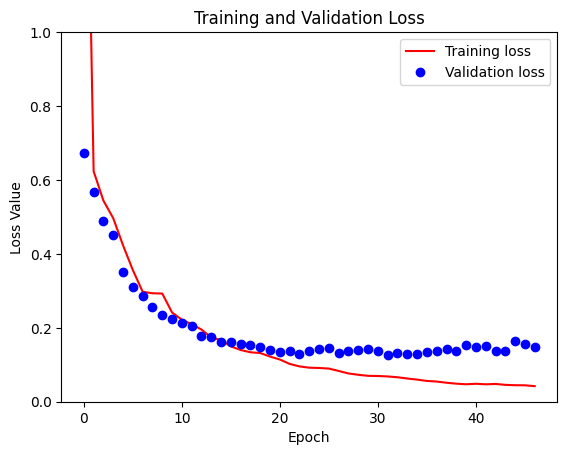

In [43]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### **5. TEST** ###

5.1 test 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


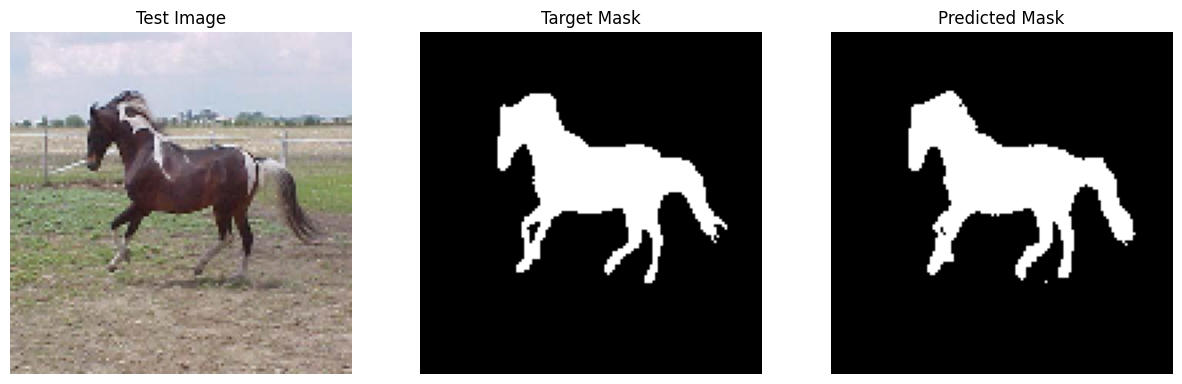

In [62]:
MG_HEIGHT = 128
IMG_WIDTH = 128
# 028 - 124 - 295
# DA TENERE 050 - 045 - 037 - 267 - 041 (pos) 
# test image
test_image_path = "../training_data/horses/horse162.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# mask
test_mask_path = "../training_data/masks/horse162.png" # 218 283 315 273
test_mask = np.array(Image.open(test_mask_path)) 


# Fai una predizione sull'immagine di test
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
# Soglia per la maschera predetta
threshold = 0.2  # Puoi regolare questa soglia secondo le tue esigenze
# Applica la soglia alla maschera predetta
binary_mask = predicted_mask > threshold


# Visualizza l'immagine di test e la maschera target sulla stessa riga
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot dell'immagine di test
axes[0].imshow(rescaled_test_image)
axes[0].set_title('Test Image')
axes[0].axis('off')  # Rimuovi gli assi
# Plot della maschera target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot della maschera predetta
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


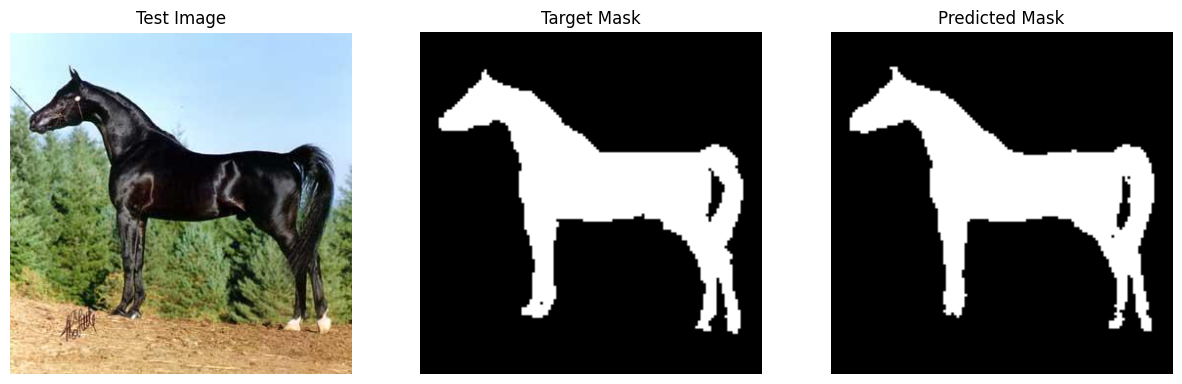

In [48]:
MG_HEIGHT = 128
IMG_WIDTH = 128

# test image
test_image_path = "../test_data/horses/horse315.png" # 218 283 315 273
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# mask
test_mask_path = "../test_data/masks/horse315.png" # 218 283 315 273
test_mask = np.array(Image.open(test_mask_path)) 
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
threshold = 0.5 
binary_mask = predicted_mask > threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot image test
axes[0].imshow(test_image)
axes[0].set_title('Test Image')
axes[0].axis('off') 
# Plot mask target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot mask target
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


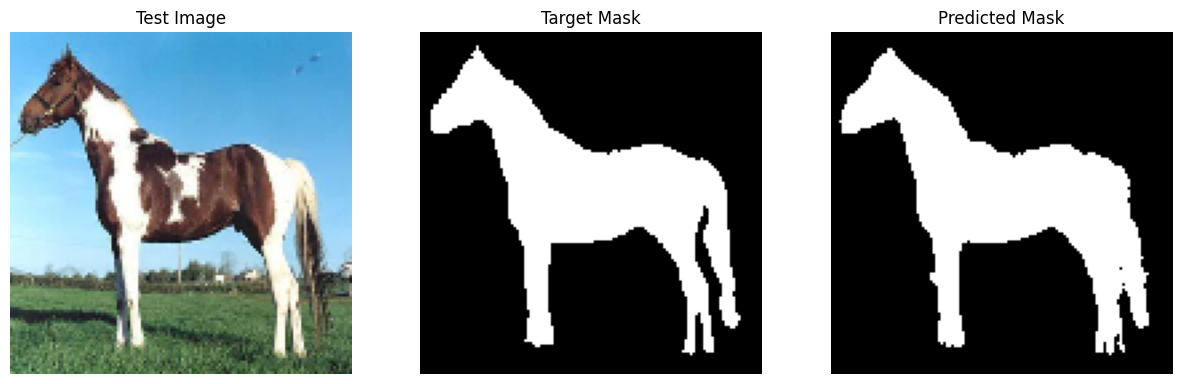

In [49]:
MG_HEIGHT = 128
IMG_WIDTH = 128

# test image
test_image_path = "../test_data/horses/horse069.png" # 218 283 
test_image = np.array(Image.open(test_image_path)) 
rescaled_test_image = cv2.resize(test_image, (IMG_HEIGHT, IMG_WIDTH))

# test mask
test_mask_path = "../test_data/masks/horse069.png" # 218 283 
test_mask = np.array(Image.open(test_mask_path)) 

# predicted mask
predicted_mask = model.predict(np.expand_dims(rescaled_test_image, axis=0))[0]
threshold = 0.5 
binary_mask = predicted_mask > threshold

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot image test
axes[0].imshow(rescaled_test_image)
axes[0].set_title('Test Image')
axes[0].axis('off') 
# Plot mask target
test_mask_rescale = cv2.resize(test_mask, (IMG_WIDTH, IMG_HEIGHT))
axes[1].imshow(test_mask_rescale, cmap='gray')
axes[1].set_title('Target Mask')
axes[1].axis('off')
# Plot mask target
axes[2].imshow(binary_mask, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')  # Rimuovi gli assi

plt.show()

### **X. Test con altri modelli** ###
X.1 FNC 
Come primo modello ho deciso 